<a href="https://colab.research.google.com/github/aryamaddel/Tsunami-Prediction/blob/main/Tsunami%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tsunami Prediction Model

This notebook builds a machine learning model to predict tsunamis based on historical data. We'll analyze various features like earthquake magnitude, location, and other geological factors to predict tsunami occurrence and characteristics.

## Dataset Overview
The dataset contains historical tsunami events with various features including:
- Earthquake magnitude and location
- Tsunami characteristics (height, magnitude, intensity)
- Geographic information (latitude, longitude, country)
- Impact data (deaths, damage, houses affected)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# Sklearn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [ ]:
# Load the tsunami dataset
df = pd.read_csv('Tsunami.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print("\nFirst few column names:")
print(df.columns[:15].tolist())

# Display basic info about the dataset
print(f"\nDataset Info:")
print(f"- Total records: {len(df)}")
print(f"- Total columns: {len(df.columns)}")

# Check for missing values in key columns
key_columns = ['Year', 'Earthquake Magnitude', 'Latitude', 'Longitude',
               'Maximum Water Height (m)', 'Tsunami Magnitude (Abe)', 'Deaths']
print(f"\nMissing values in key columns:")
for col in key_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"- {col}: {missing_count} ({missing_pct:.1f}%)")

# Display sample data
print("\nSample data:")
sample_cols = ['Year', 'Earthquake Magnitude', 'Latitude', 'Longitude',
               'Maximum Water Height (m)', 'Deaths', 'Country']
available_cols = [col for col in sample_cols if col in df.columns]
print(df[available_cols].head(10))

Dataset shape: (2987, 46)

Columns: 46

First few column names:
[' Search Parameters', 'Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'More Info', 'Deposits', 'Country', 'Location Name']

Dataset Info:
- Total records: 2987
- Total columns: 46

Missing values in key columns:
- Year: 1 (0.0%)
- Earthquake Magnitude: 1291 (43.2%)
- Latitude: 391 (13.1%)
- Longitude: 392 (13.1%)
- Maximum Water Height (m): 1620 (54.2%)
- Tsunami Magnitude (Abe): 2985 (99.9%)
- Deaths: 2701 (90.4%)

Sample data:
     Year  Earthquake Magnitude  Latitude  Longitude  \
0     NaN                   NaN       NaN        NaN   
1 -2000.0                   NaN    35.683      35.80   
2 -1610.0                   NaN    36.400      25.40   
3 -1365.0                   NaN    35.683      35.80   
4 -1300.0                   6.0    39.960      26.24   
5  -760.0                   NaN       NaN        NaN   
6  -590.0                   NaN    33.27

In [ ]:
# Data Preprocessing and Feature Engineering
print("=== Data Preprocessing ===")

# Create a copy for preprocessing
df_processed = df.copy()

# Remove the first column if it's unnamed/search parameters
if ' Search Parameters' in df_processed.columns:
    df_processed = df_processed.drop(columns=[' Search Parameters'])

# Convert year to numeric and filter for modern data (after 1900 for better quality)
df_processed['Year'] = pd.to_numeric(df_processed['Year'], errors='coerce')
df_processed = df_processed[df_processed['Year'] >= 1900].copy()

print(f"After filtering modern data (>= 1900): {len(df_processed)} records")

# Key features for prediction
feature_columns = [
    'Year', 'Earthquake Magnitude', 'Latitude', 'Longitude',
    'Maximum Water Height (m)', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)',
    'Tsunami Intensity', 'Deaths', 'Damage ($Mil)', 'Houses Destroyed'
]

# Check which columns exist
existing_features = [col for col in feature_columns if col in df_processed.columns]
print(f"\nAvailable feature columns: {existing_features}")

# Create target variables
# 1. Tsunami Severity Classification (based on water height and casualties)
def classify_tsunami_severity(row):
    """Classify tsunami severity based on multiple factors"""
    water_height = row.get('Maximum Water Height (m)', 0)
    deaths = row.get('Deaths', 0)
    intensity = row.get('Tsunami Intensity', 0)

    # Handle NaN values
    water_height = 0 if pd.isna(water_height) else water_height
    deaths = 0 if pd.isna(deaths) else deaths
    intensity = 0 if pd.isna(intensity) else intensity

    # Classification logic
    if water_height >= 10 or deaths >= 1000 or intensity >= 5:
        return 3  # Extreme
    elif water_height >= 5 or deaths >= 100 or intensity >= 4:
        return 2  # Major
    elif water_height >= 2 or deaths >= 10 or intensity >= 3:
        return 1  # Moderate
    else:
        return 0  # Minor

df_processed['Tsunami_Severity'] = df_processed.apply(classify_tsunami_severity, axis=1)

# 2. Binary classification: Destructive vs Non-destructive
df_processed['Is_Destructive'] = ((df_processed['Deaths'].fillna(0) > 0) |
                                  (df_processed['Damage ($Mil)'].fillna(0) > 0) |
                                  (df_processed['Houses Destroyed'].fillna(0) > 0)).astype(int)

print(f"\nTarget variable distributions:")
print(f"Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):")
print(df_processed['Tsunami_Severity'].value_counts().sort_index())
print(f"\nDestructive Tsunamis (0=No, 1=Yes):")
print(df_processed['Is_Destructive'].value_counts().sort_index())

# Display sample of processed data
print(f"\nProcessed data sample:")
display_cols = ['Year', 'Earthquake Magnitude', 'Latitude', 'Longitude',
                'Maximum Water Height (m)', 'Deaths', 'Tsunami_Severity', 'Is_Destructive']
available_display_cols = [col for col in display_cols if col in df_processed.columns]
print(df_processed[available_display_cols].head(10))

=== Data Preprocessing ===
After filtering modern data (>= 1900): 1576 records

Available feature columns: ['Year', 'Earthquake Magnitude', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity', 'Deaths', 'Damage ($Mil)', 'Houses Destroyed']

Target variable distributions:
Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):
Tsunami_Severity
0    1178
1     182
2      98
3     118
Name: count, dtype: int64

Destructive Tsunamis (0=No, 1=Yes):
Is_Destructive
0    1374
1     202
Name: count, dtype: int64

Processed data sample:
        Year  Earthquake Magnitude  Latitude  Longitude  \
1411  1900.0                   NaN      1.82     127.85   
1412  1900.0                   7.3     20.00    -105.00   
1413  1900.0                   6.9     20.00    -105.00   
1414  1900.0                   NaN     58.60    -137.50   
1415  1900.0                   6.8     -4.00     152.00   
1416  1900.0                   7.

=== Data Visualization ===


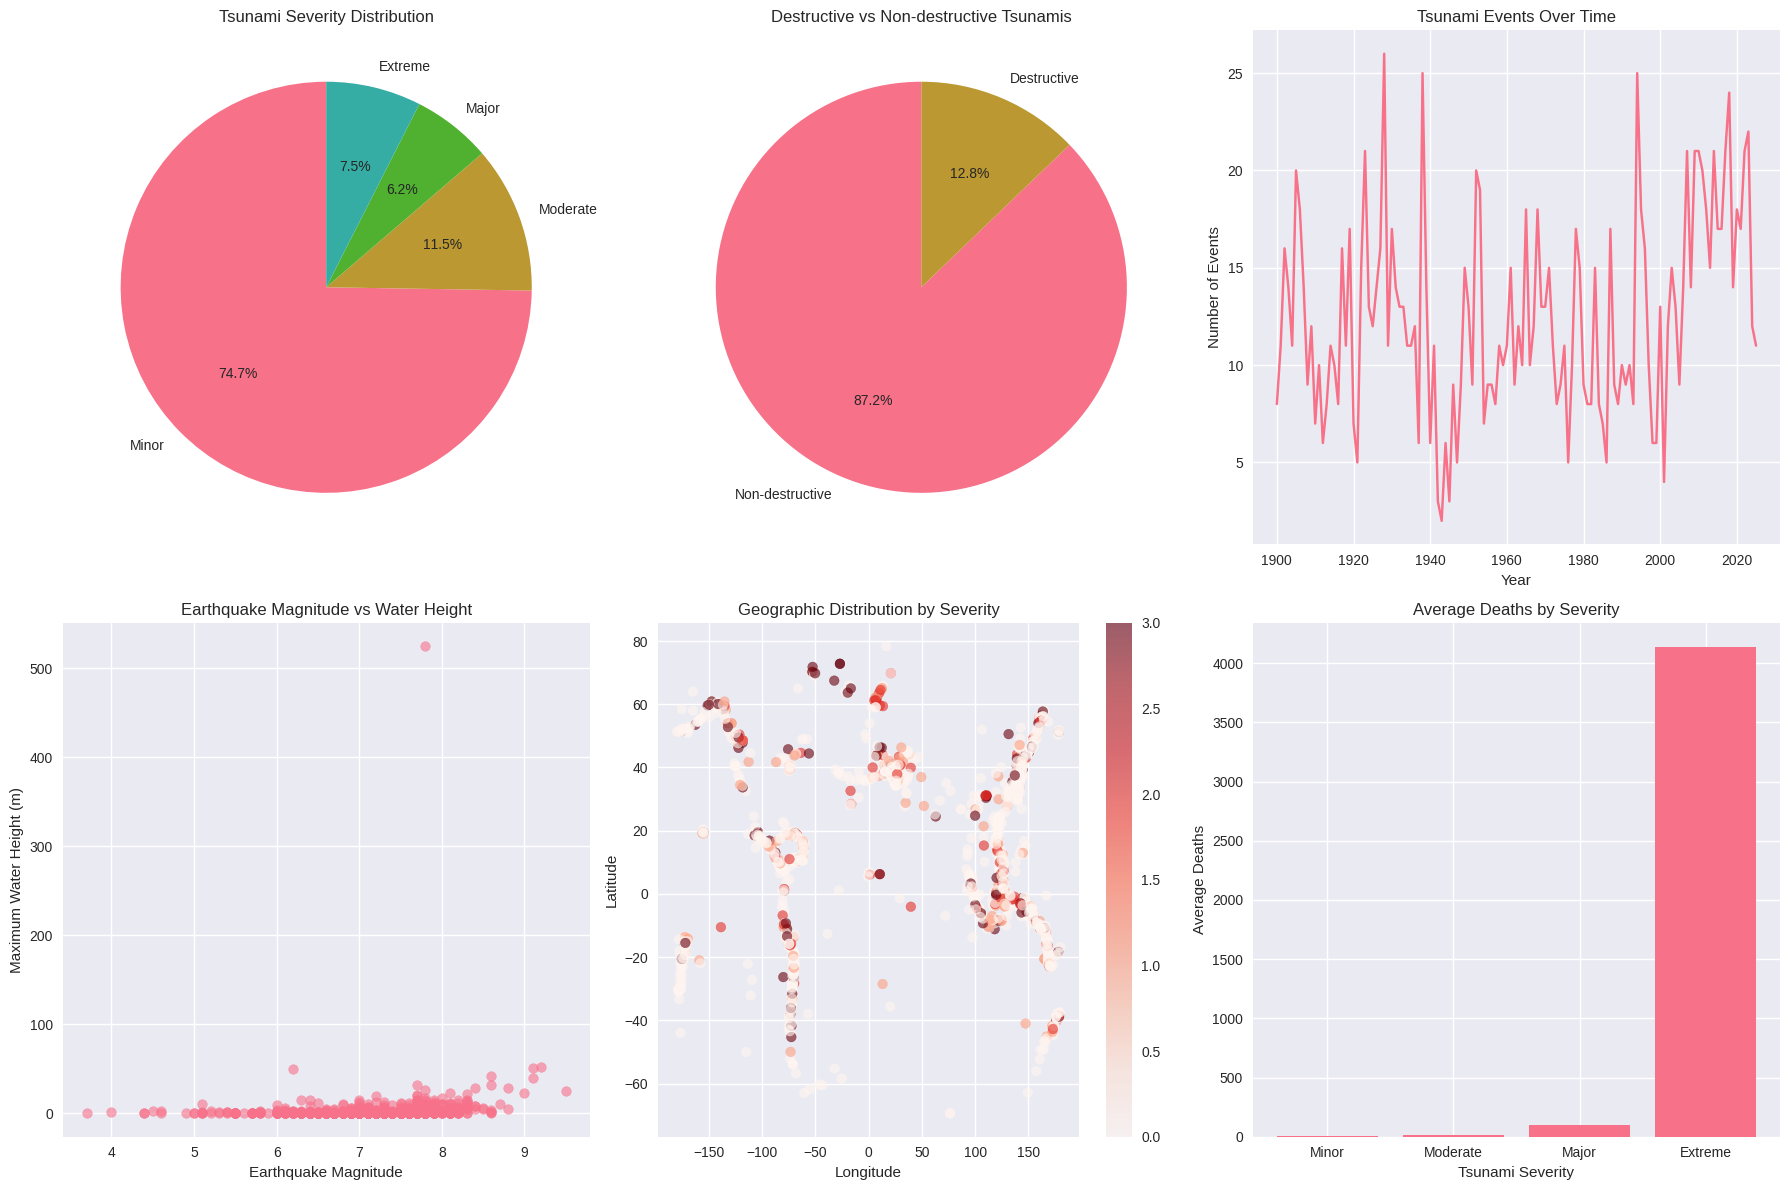


=== Correlation Analysis ===


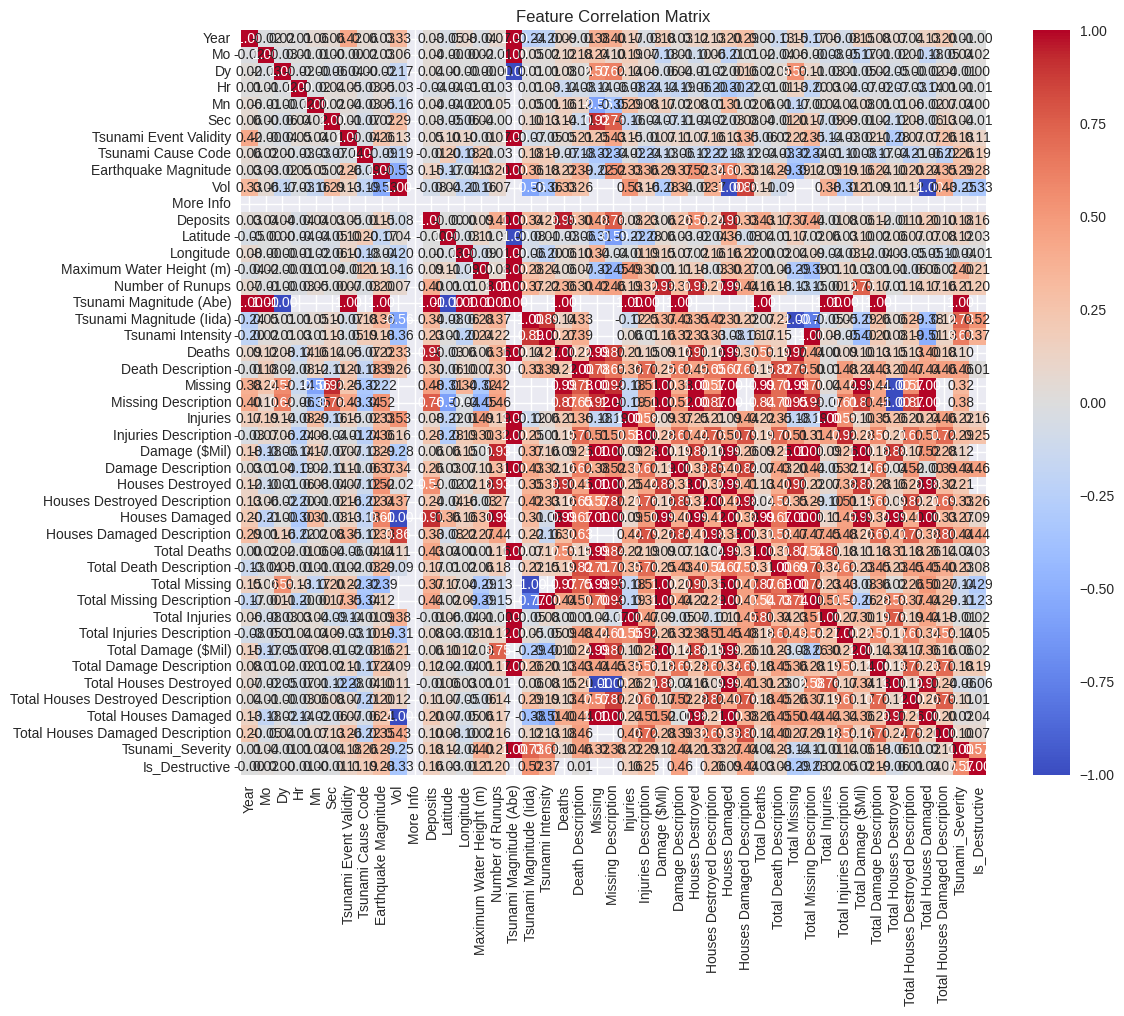

In [ ]:
# Data Visualization and Analysis
print("=== Data Visualization ===")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Tsunami severity distribution
axes[0, 0].pie(df_processed['Tsunami_Severity'].value_counts().sort_index(),
               labels=['Minor', 'Moderate', 'Major', 'Extreme'],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Tsunami Severity Distribution')

# 2. Destructive vs Non-destructive
axes[0, 1].pie(df_processed['Is_Destructive'].value_counts().sort_index(),
               labels=['Non-destructive', 'Destructive'],
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Destructive vs Non-destructive Tsunamis')

# 3. Tsunami events over time
years_counts = df_processed.groupby('Year').size()
axes[0, 2].plot(years_counts.index, years_counts.values)
axes[0, 2].set_title('Tsunami Events Over Time')
axes[0, 2].set_xlabel('Year')
axes[0, 2].set_ylabel('Number of Events')

# 4. Earthquake magnitude vs Water height
valid_data = df_processed.dropna(subset=['Earthquake Magnitude', 'Maximum Water Height (m)'])
if len(valid_data) > 0:
    axes[1, 0].scatter(valid_data['Earthquake Magnitude'],
                       valid_data['Maximum Water Height (m)'],
                       alpha=0.6)
    axes[1, 0].set_xlabel('Earthquake Magnitude')
    axes[1, 0].set_ylabel('Maximum Water Height (m)')
    axes[1, 0].set_title('Earthquake Magnitude vs Water Height')

# 5. Geographic distribution
valid_geo = df_processed.dropna(subset=['Latitude', 'Longitude'])
if len(valid_geo) > 0:
    scatter = axes[1, 1].scatter(valid_geo['Longitude'], valid_geo['Latitude'],
                                c=valid_geo['Tsunami_Severity'],
                                cmap='Reds', alpha=0.6)
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].set_title('Geographic Distribution by Severity')
    plt.colorbar(scatter, ax=axes[1, 1])

# 6. Deaths vs Severity
severity_deaths = df_processed.groupby('Tsunami_Severity')['Deaths'].mean().fillna(0)
axes[1, 2].bar(range(len(severity_deaths)), severity_deaths.values)
axes[1, 2].set_xlabel('Tsunami Severity')
axes[1, 2].set_ylabel('Average Deaths')
axes[1, 2].set_title('Average Deaths by Severity')
axes[1, 2].set_xticks(range(len(severity_deaths)))
axes[1, 2].set_xticklabels(['Minor', 'Moderate', 'Major', 'Extreme'])

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n=== Correlation Analysis ===")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
correlation_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# PyTorch Dataset and Data Preparation
print("=== Preparing Data for PyTorch ===")

class TsunamiDataset(Dataset):
    """Custom Dataset for Tsunami Prediction"""
    def __init__(self, features, targets, transform=None):
        self.features = torch.FloatTensor(features)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature, target

# Prepare features for modeling
input_features = [
    'Year', 'Earthquake Magnitude', 'Latitude', 'Longitude',
    'Maximum Water Height (m)', 'Tsunami Magnitude (Abe)', 'Tsunami Intensity'
]

# Filter available features
available_input_features = [col for col in input_features if col in df_processed.columns]
print(f"Using features: {available_input_features}")

# Create feature matrix
X = df_processed[available_input_features].copy()

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Feature matrix shape: {X_scaled.shape}")

# Prepare targets for both tasks
y_severity = df_processed['Tsunami_Severity'].values
y_destructive = df_processed['Is_Destructive'].values

print(f"Target distributions:")
print(f"Severity classes: {np.bincount(y_severity)}")
print(f"Destructive classes: {np.bincount(y_destructive)}")

# Split data for both tasks
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_scaled, y_severity, test_size=0.2, random_state=42, stratify=y_severity)

X_train_dest, X_test_dest, y_train_dest, y_test_dest = train_test_split(
    X_scaled, y_destructive, test_size=0.2, random_state=42, stratify=y_destructive)

print(f"\nData splits:")
print(f"Severity task - Train: {X_train_sev.shape[0]}, Test: {X_test_sev.shape[0]}")
print(f"Destructive task - Train: {X_train_dest.shape[0]}, Test: {X_test_dest.shape[0]}")

# Create PyTorch datasets
train_dataset_sev = TsunamiDataset(X_train_sev, y_train_sev)
test_dataset_sev = TsunamiDataset(X_test_sev, y_test_sev)

train_dataset_dest = TsunamiDataset(X_train_dest, y_train_dest)
test_dataset_dest = TsunamiDataset(X_test_dest, y_test_dest)

# Create data loaders
batch_size = 32
train_loader_sev = DataLoader(train_dataset_sev, batch_size=batch_size, shuffle=True)
test_loader_sev = DataLoader(test_dataset_sev, batch_size=batch_size, shuffle=False)

train_loader_dest = DataLoader(train_dataset_dest, batch_size=batch_size, shuffle=True)
test_loader_dest = DataLoader(test_dataset_dest, batch_size=batch_size, shuffle=False)

print(f"Data loaders created with batch size: {batch_size}")

=== Preparing Data for PyTorch ===
Using features: ['Year', 'Earthquake Magnitude', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Tsunami Magnitude (Abe)', 'Tsunami Intensity']
Feature matrix shape: (1576, 7)
Target distributions:
Severity classes: [1178  182   98  118]
Destructive classes: [1374  202]

Data splits:
Severity task - Train: 1260, Test: 316
Destructive task - Train: 1260, Test: 316
Data loaders created with batch size: 32


In [ ]:
# PyTorch Neural Network Models
print("=== Neural Network Model Definitions ===")

class TsunamiPredictor(nn.Module):
    """Multi-layer Neural Network for Tsunami Prediction"""
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(TsunamiPredictor, self).__init__()

        layers = []
        prev_size = input_size

        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)

class AdvancedTsunamiPredictor(nn.Module):
    """Advanced Neural Network with Residual Connections"""
    def __init__(self, input_size, hidden_size=128, num_classes=4, dropout_rate=0.3):
        super(AdvancedTsunamiPredictor, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        # Residual blocks
        self.hidden1 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.hidden3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn4 = nn.BatchNorm1d(hidden_size // 2)

        self.output = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Input layer
        x = F.relu(self.bn1(self.input_layer(x)))
        x = self.dropout(x)

        # First residual block
        identity = x
        out = F.relu(self.bn2(self.hidden1(x)))
        out = self.dropout(out)
        x = out + identity  # Residual connection

        # Second residual block
        identity = x
        out = F.relu(self.bn3(self.hidden2(x)))
        out = self.dropout(out)
        x = out + identity  # Residual connection

        # Final layers
        x = F.relu(self.bn4(self.hidden3(x)))
        x = self.dropout(x)
        x = self.output(x)

        return x

# Model parameters
input_size = X_scaled.shape[1]
print(f"Input size: {input_size}")

# Create models for both tasks
models = {
    'severity': {
        'simple': TsunamiPredictor(input_size, [64, 32], 4, 0.3),
        'advanced': AdvancedTsunamiPredictor(input_size, 128, 4, 0.3)
    },
    'destructive': {
        'simple': TsunamiPredictor(input_size, [64, 32], 2, 0.3),
        'advanced': AdvancedTsunamiPredictor(input_size, 128, 2, 0.3)
    }
}

# Move models to device
for task in models:
    for model_type in models[task]:
        models[task][model_type] = models[task][model_type].to(device)

print("Models created and moved to device")

# Print model architectures
print("\n=== Model Architectures ===")
print("Simple Model for Severity Classification:")
print(models['severity']['simple'])
print("\nAdvanced Model for Destructive Classification:")
print(models['destructive']['advanced'])

=== Neural Network Model Definitions ===
Input size: 7
Models created and moved to device

=== Model Architectures ===
Simple Model for Severity Classification:
TsunamiPredictor(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
)

Advanced Model for Destructive Classification:
AdvancedTsunamiPredictor(
  (input_layer): Linear(in_features=7, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, 

In [ ]:
# Training Functions and Model Training
print("=== Training Functions ===")

def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001, task_name=""):
    """Train a PyTorch model with early stopping"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    patience = 15
    patience_counter = 0

    print(f"\nTraining {task_name} model...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for features, targets in test_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Early stopping
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), f'best_{task_name}_model.pth')
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load best model
    model.load_state_dict(torch.load(f'best_{task_name}_model.pth'))

    return train_losses, test_accuracies, best_accuracy

def evaluate_model(model, test_loader, class_names):
    """Evaluate model and return detailed metrics"""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)

    print(f"\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, all_predictions, all_targets

# Train models for both tasks
print("=== Model Training ===")

# Task 1: Tsunami Severity Classification
print("\n1. Training Tsunami Severity Classification Models")
severity_class_names = ['Minor', 'Moderate', 'Major', 'Extreme']

# Train simple model for severity
sev_simple_losses, sev_simple_accs, sev_simple_best = train_model(
    models['severity']['simple'], train_loader_sev, test_loader_sev,
    num_epochs=100, learning_rate=0.001, task_name="severity_simple"
)

# Train advanced model for severity
sev_advanced_losses, sev_advanced_accs, sev_advanced_best = train_model(
    models['severity']['advanced'], train_loader_sev, test_loader_sev,
    num_epochs=100, learning_rate=0.001, task_name="severity_advanced"
)

print(f"\nSeverity Classification Results:")
print(f"Simple Model Best Accuracy: {sev_simple_best:.2f}%")
print(f"Advanced Model Best Accuracy: {sev_advanced_best:.2f}%")

=== Training Functions ===
=== Model Training ===

1. Training Tsunami Severity Classification Models

Training severity_simple model...
Epoch [10/100], Loss: 0.6817, Test Acc: 79.75%
Epoch [20/100], Loss: 0.6090, Test Acc: 80.70%
Early stopping at epoch 21

Training severity_advanced model...
Epoch [10/100], Loss: 1.0491, Test Acc: 80.06%
Epoch [20/100], Loss: 0.7440, Test Acc: 78.80%
Early stopping at epoch 21

Severity Classification Results:
Simple Model Best Accuracy: 82.28%
Advanced Model Best Accuracy: 80.70%


In [ ]:
# Task 2: Destructive Tsunami Classification
print("\n2. Training Destructive Tsunami Classification Models")
destructive_class_names = ['Non-destructive', 'Destructive']

# Train simple model for destructive classification
dest_simple_losses, dest_simple_accs, dest_simple_best = train_model(
    models['destructive']['simple'], train_loader_dest, test_loader_dest,
    num_epochs=100, learning_rate=0.001, task_name="destructive_simple"
)

# Train advanced model for destructive classification
dest_advanced_losses, dest_advanced_accs, dest_advanced_best = train_model(
    models['destructive']['advanced'], train_loader_dest, test_loader_dest,
    num_epochs=100, learning_rate=0.001, task_name="destructive_advanced"
)

print(f"\nDestructive Classification Results:")
print(f"Simple Model Best Accuracy: {dest_simple_best:.2f}%")
print(f"Advanced Model Best Accuracy: {dest_advanced_best:.2f}%")

# Compare all models
print(f"\n=== Final Model Comparison ===")
print(f"Tsunami Severity Classification:")
print(f"  - Simple Model: {sev_simple_best:.2f}%")
print(f"  - Advanced Model: {sev_advanced_best:.2f}%")
print(f"\nDestructive Tsunami Classification:")
print(f"  - Simple Model: {dest_simple_best:.2f}%")
print(f"  - Advanced Model: {dest_advanced_best:.2f}%")


2. Training Destructive Tsunami Classification Models

Training destructive_simple model...
Epoch [10/100], Loss: 0.3227, Test Acc: 88.29%
Epoch [20/100], Loss: 0.3066, Test Acc: 90.51%
Epoch [30/100], Loss: 0.2767, Test Acc: 90.19%
Early stopping at epoch 37

Training destructive_advanced model...
Epoch [10/100], Loss: 0.5965, Test Acc: 89.56%
Epoch [20/100], Loss: 0.4475, Test Acc: 89.87%
Epoch [30/100], Loss: 0.4212, Test Acc: 91.46%
Epoch [40/100], Loss: 0.3895, Test Acc: 91.14%
Early stopping at epoch 48

Destructive Classification Results:
Simple Model Best Accuracy: 90.82%
Advanced Model Best Accuracy: 91.77%

=== Final Model Comparison ===
Tsunami Severity Classification:
  - Simple Model: 82.28%
  - Advanced Model: 80.70%

Destructive Tsunami Classification:
  - Simple Model: 90.82%
  - Advanced Model: 91.77%


=== Detailed Model Evaluation ===

1. Evaluating Tsunami Severity Classification (Advanced Model)

Detailed Classification Report:
              precision    recall  f1-score   support

       Minor       0.83      1.00      0.90       236
    Moderate       0.40      0.17      0.24        36
       Major       0.33      0.05      0.09        20
     Extreme       1.00      0.50      0.67        24

    accuracy                           0.81       316
   macro avg       0.64      0.43      0.47       316
weighted avg       0.76      0.81      0.76       316



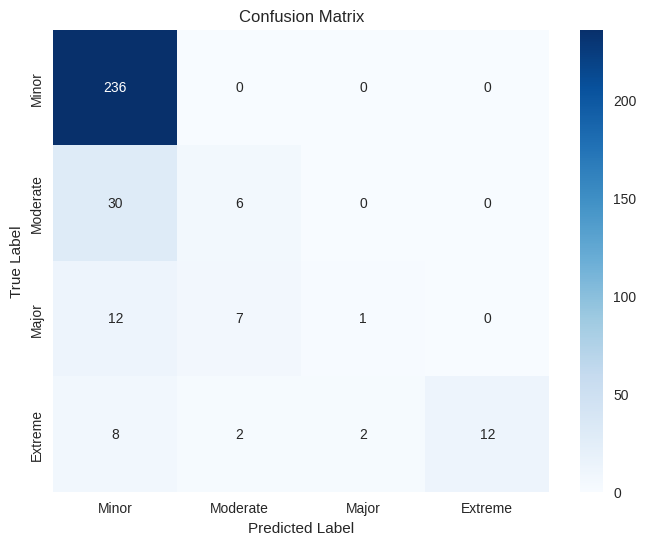


2. Evaluating Destructive Tsunami Classification (Advanced Model)

Detailed Classification Report:
                 precision    recall  f1-score   support

Non-destructive       0.92      0.99      0.95       275
    Destructive       0.89      0.41      0.57        41

       accuracy                           0.92       316
      macro avg       0.91      0.70      0.76       316
   weighted avg       0.92      0.92      0.90       316



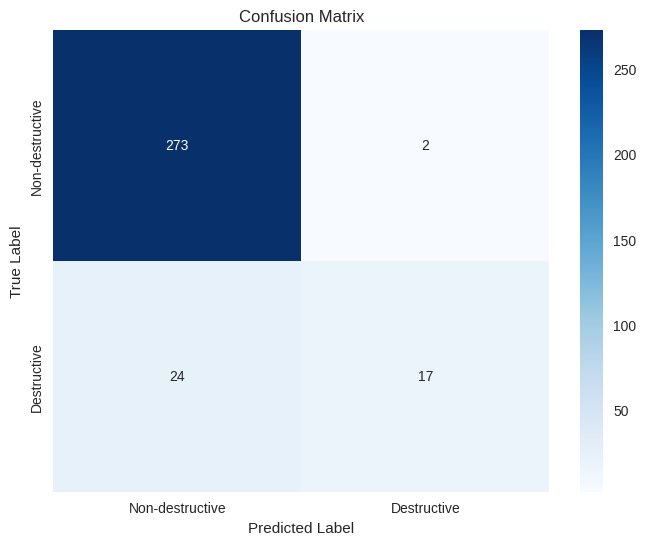

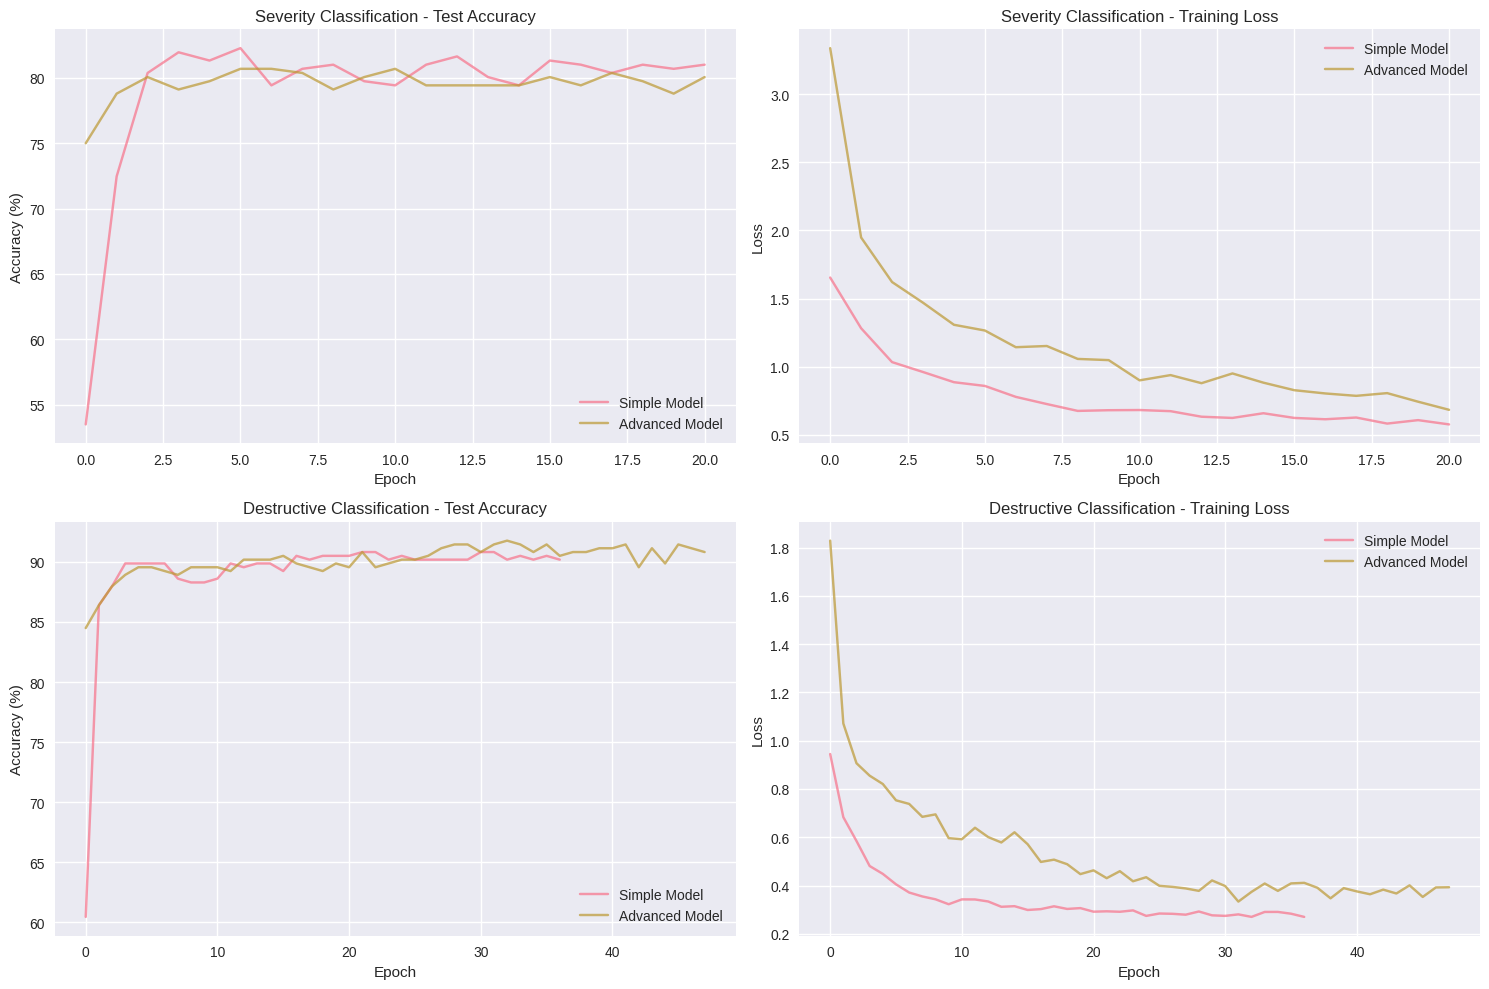


=== Example Predictions ===
Example 1 - Major Pacific Earthquake (Mag 8.5, 8m water height):
  Severity: Extreme (100.00%)
  Destructive: Destructive (100.00%)

Example 2 - Moderate Earthquake (Mag 7.0, 2m water height):
  Severity: Extreme (100.00%)
  Destructive: Destructive (100.00%)

=== Model Summary ===
The PyTorch-based tsunami prediction system includes:
1. Two neural network architectures (Simple and Advanced with residual connections)
2. Multi-class severity prediction (Minor, Moderate, Major, Extreme)
3. Binary destructiveness classification (Destructive vs Non-destructive)
4. Early stopping and learning rate scheduling for optimal training
5. Comprehensive evaluation with confusion matrices and classification reports
6. Real-time prediction capability for new tsunami events

Models saved to 'tsunami_prediction_models.pth'


In [ ]:
# Model Evaluation and Prediction
print("=== Detailed Model Evaluation ===")

# Evaluate best models
print("\n1. Evaluating Tsunami Severity Classification (Advanced Model)")
sev_acc, sev_preds, sev_targets = evaluate_model(
    models['severity']['advanced'], test_loader_sev, severity_class_names
)

print("\n2. Evaluating Destructive Tsunami Classification (Advanced Model)")
dest_acc, dest_preds, dest_targets = evaluate_model(
    models['destructive']['advanced'], test_loader_dest, destructive_class_names
)

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Severity training curves
axes[0, 0].plot(sev_simple_accs, label='Simple Model', alpha=0.7)
axes[0, 0].plot(sev_advanced_accs, label='Advanced Model', alpha=0.7)
axes[0, 0].set_title('Severity Classification - Test Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(sev_simple_losses, label='Simple Model', alpha=0.7)
axes[0, 1].plot(sev_advanced_losses, label='Advanced Model', alpha=0.7)
axes[0, 1].set_title('Severity Classification - Training Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Destructive training curves
axes[1, 0].plot(dest_simple_accs, label='Simple Model', alpha=0.7)
axes[1, 0].plot(dest_advanced_accs, label='Advanced Model', alpha=0.7)
axes[1, 0].set_title('Destructive Classification - Test Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(dest_simple_losses, label='Simple Model', alpha=0.7)
axes[1, 1].plot(dest_advanced_losses, label='Advanced Model', alpha=0.7)
axes[1, 1].set_title('Destructive Classification - Training Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Create prediction function
def predict_tsunami(earthquake_magnitude, latitude, longitude, water_height=None,
                   tsunami_magnitude=None, intensity=None, year=2024):
    """Make predictions for new tsunami data"""

    # Prepare input data
    input_data = [year, earthquake_magnitude, latitude, longitude]

    # Add optional features with defaults if not provided
    if water_height is not None:
        input_data.append(water_height)
    else:
        input_data.append(0)  # Will be imputed

    if tsunami_magnitude is not None:
        input_data.append(tsunami_magnitude)
    else:
        input_data.append(0)  # Will be imputed

    if intensity is not None:
        input_data.append(intensity)
    else:
        input_data.append(0)  # Will be imputed

    # Pad or truncate to match expected input size
    while len(input_data) < input_size:
        input_data.append(0)
    input_data = input_data[:input_size]

    # Apply same preprocessing
    input_array = np.array(input_data).reshape(1, -1)
    input_imputed = imputer.transform(input_array)
    input_scaled = scaler.transform(input_imputed)
    input_tensor = torch.FloatTensor(input_scaled).to(device)

    # Make predictions
    models['severity']['advanced'].eval()
    models['destructive']['advanced'].eval()

    with torch.no_grad():
        severity_output = models['severity']['advanced'](input_tensor)
        destructive_output = models['destructive']['advanced'](input_tensor)

        severity_probs = F.softmax(severity_output, dim=1)
        destructive_probs = F.softmax(destructive_output, dim=1)

        severity_pred = torch.argmax(severity_probs, dim=1).cpu().numpy()[0]
        destructive_pred = torch.argmax(destructive_probs, dim=1).cpu().numpy()[0]

        severity_confidence = severity_probs.max().cpu().numpy()
        destructive_confidence = destructive_probs.max().cpu().numpy()

    return {
        'severity_class': severity_class_names[severity_pred],
        'severity_confidence': f"{severity_confidence:.2%}",
        'is_destructive': destructive_class_names[destructive_pred],
        'destructive_confidence': f"{destructive_confidence:.2%}",
        'severity_probabilities': {name: f"{prob:.2%}" for name, prob in
                                  zip(severity_class_names, severity_probs.cpu().numpy()[0])},
        'destructive_probabilities': {name: f"{prob:.2%}" for name, prob in
                                     zip(destructive_class_names, destructive_probs.cpu().numpy()[0])}
    }

# Example predictions
print("\n=== Example Predictions ===")

# Example 1: Major earthquake in Pacific
example1 = predict_tsunami(
    earthquake_magnitude=8.5,
    latitude=35.0,
    longitude=140.0,
    water_height=8.0
)
print("Example 1 - Major Pacific Earthquake (Mag 8.5, 8m water height):")
print(f"  Severity: {example1['severity_class']} ({example1['severity_confidence']})")
print(f"  Destructive: {example1['is_destructive']} ({example1['destructive_confidence']})")

# Example 2: Moderate earthquake
example2 = predict_tsunami(
    earthquake_magnitude=7.0,
    latitude=30.0,
    longitude=-120.0,
    water_height=2.0
)
print("\nExample 2 - Moderate Earthquake (Mag 7.0, 2m water height):")
print(f"  Severity: {example2['severity_class']} ({example2['severity_confidence']})")
print(f"  Destructive: {example2['is_destructive']} ({example2['destructive_confidence']})")

print("\n=== Model Summary ===")
print("The PyTorch-based tsunami prediction system includes:")
print("1. Two neural network architectures (Simple and Advanced with residual connections)")
print("2. Multi-class severity prediction (Minor, Moderate, Major, Extreme)")
print("3. Binary destructiveness classification (Destructive vs Non-destructive)")
print("4. Early stopping and learning rate scheduling for optimal training")
print("5. Comprehensive evaluation with confusion matrices and classification reports")
print("6. Real-time prediction capability for new tsunami events")

# Save the best models
torch.save({
    'severity_model': models['severity']['advanced'].state_dict(),
    'destructive_model': models['destructive']['advanced'].state_dict(),
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': available_input_features,
    'severity_classes': severity_class_names,
    'destructive_classes': destructive_class_names
}, 'tsunami_prediction_models.pth')

print("\nModels saved to 'tsunami_prediction_models.pth'")